# sequence prediction sandbox


In [1]:
import torch
from torch import nn

from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u

In [2]:
# create all possible n-mers for 6 and 8
seqs6 = [''.join(x) for x in product(['A','C','G','T'], repeat=6)]
print('Total 6mers:',len(seqs6))

seqs8 = [''.join(x) for x in product(['A','C','G','T'], repeat=8)]
print('Total 8mers:',len(seqs8))

Total 6mers: 4096
Total 8mers: 65536


In [3]:
# if you want to down select
seqs6_200 = u.downselect_list(seqs6,200)
seqs8_200 = u.downselect_list(seqs8,200)

In [4]:
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}
def score_seqs(seqs):
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
                  
def score_seqs_motif(seqs):
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        if 'TAT' in seq:
            score += 10
        if 'GCG' in seq:
            score -= 10
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
    

In [5]:
mer6 = score_seqs(seqs6)
mer6.head()

,seq,score
0,AAAAAA,20.0
1,AAAAAC,19.5
2,AAAAAG,19.0
3,AAAAAT,18.5
4,AAAACA,19.5


In [6]:
mer8 = score_seqs(seqs8)
mer8.head()

,seq,score
0,AAAAAAAA,20.000
1,AAAAAAAC,19.625
2,AAAAAAAG,19.250
3,AAAAAAAT,18.875
4,AAAAAACA,19.625


In [7]:
mer6_motif = score_seqs_motif(seqs6)
mer8_motif = score_seqs_motif(seqs8)


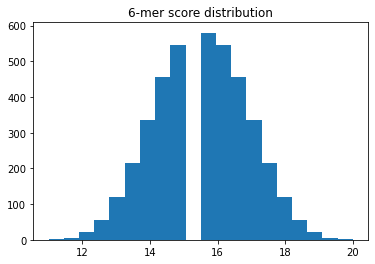

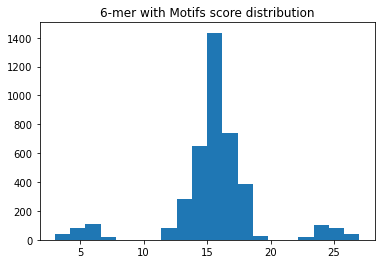

In [8]:
plt.hist(mer6['score'].values,bins=20)
plt.title("6-mer score distribution")
plt.show()

plt.hist(mer6_motif['score'].values,bins=20)
plt.title("6-mer with Motifs score distribution")
plt.show()

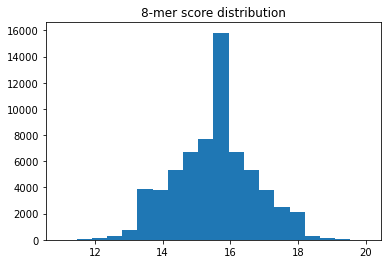

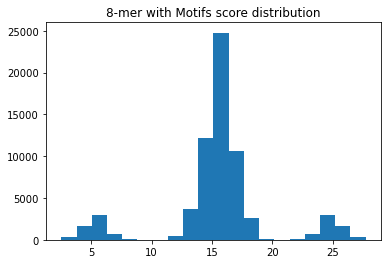

In [9]:
plt.hist(mer8['score'].values,bins=20)
plt.title("8-mer score distribution")
plt.show()

plt.hist(mer8_motif['score'].values,bins=20)
plt.title("8-mer with Motifs score distribution")
plt.show()

### Define some basic model archs for Linear and CNN

In [10]:
class DNA_Linear(nn.Module):
    def __init__(self, seq_len,h1_size):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 1),
            nn.ReLU(inplace=True)
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    

    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

# Single Task, Simple Sequence Regression
#### Linear Regression

In [11]:
mer6_train_dl, mer6_test_dl, mer6_train_df, mer6_test_df = u.build_dataloaders_single(mer6,batch_size=11)

In [12]:
def plot_train_test_hist(train_df, test_df,bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df['score'].values,bins=bins,label="train")
    plt.hist(test_df['score'].values,bins=bins,label='test')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

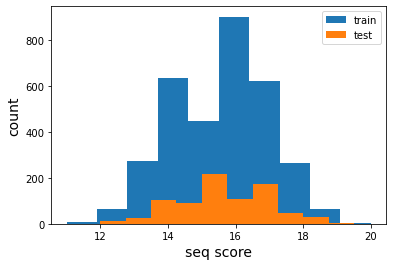

In [13]:
plot_train_test_hist(mer6_train_df, mer6_test_df)

#### Run linear model

/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


0 0.0011623799199630257
1 0.0010523620359713167
2 0.0008838477462853828
3 0.0008338474738837515
4 0.0006793571733330127
5 0.0007250696198486655
6 0.0005669204272591032
7 0.0005021003106532323
8 0.0004817861558233456
9 0.00043531464272258215
10 0.00042258325604673636
11 0.00042178726711781785
12 0.00039159969807170874
13 0.00032777110712386943
14 0.0004125408825774041
15 0.0003240578396887541
16 0.00043059420078373856
17 0.000242525333767223
18 0.00023220498581550357
19 0.00021546365494098764


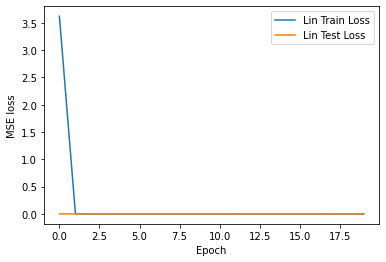

In [14]:
seq_len = len(mer6_train_df['seq'].values[0])
hidden_layer_size = 24

mer6_model_lin = DNA_Linear(seq_len, hidden_layer_size)

mer6_train_losses, mer6_test_losses = u.run_model(mer6_train_dl, mer6_test_dl, mer6_model_lin)

# to plot loss
mer6_lin_data_label = list(zip([mer6_train_losses,mer6_test_losses], ['Lin Train Loss','Lin Test Loss']))
u.quick_loss_plot(mer6_lin_data_label)

In [15]:
def quick_test(model,oracle):
    '''Spot check predictions for a few sequences '''
    seqs1 = ['AAAAAA', 'CCCCCC','GGGGGG','TTTTTT']
    seqs2 = ['AACCAA','CCGGGG','GGGTAA', 'TTTCGT','TGTAAT']
    seqsTAT = ['TATAAA','CCTATC','GTATGG','TTTATT']
    seqsGCG = ['AAGCGA','CGCGCC','GGGCGG','TTGCGT']
    TATGCG =  ['TATGCG','GCGTAT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        u.quick_seq_pred(model, seqs, oracle)
        print()

In [16]:
oracle_6mer = scoring = dict(mer6[['seq','score']].values)
quick_test(mer6_model_lin, oracle_6mer)

AAAAAA: pred:20.021 actual:20.000 (-0.021)
CCCCCC: pred:17.042 actual:17.000 (-0.042)
GGGGGG: pred:13.971 actual:14.000 (0.029)
TTTTTT: pred:11.003 actual:11.000 (-0.003)

AACCAA: pred:19.001 actual:19.000 (-0.001)
CCGGGG: pred:14.993 actual:15.000 (0.007)
GGGTAA: pred:15.502 actual:15.500 (-0.002)
TTTCGT: pred:12.526 actual:12.500 (-0.026)
TGTAAT: pred:14.500 actual:14.500 (0.000)

TATAAA: pred:17.005 actual:17.000 (-0.005)
CCTATC: pred:15.496 actual:15.500 (0.004)
GTATGG: pred:13.994 actual:14.000 (0.006)
TTTATT: pred:12.511 actual:12.500 (-0.011)

AAGCGA: pred:17.501 actual:17.500 (-0.001)
CGCGCC: pred:16.020 actual:16.000 (-0.020)
GGGCGG: pred:14.482 actual:14.500 (0.018)
TTGCGT: pred:13.008 actual:13.000 (-0.008)

TATGCG: pred:14.501 actual:14.500 (-0.001)
GCGTAT: pred:14.476 actual:14.500 (0.024)



# Single task Regression with Motifs
### Linear Model

In [17]:
mer6motif_train_dl, mer6motif_test_dl, mer6motif_train_df, mer6motif_test_df = u.build_dataloaders_single(mer6_motif,batch_size=13)

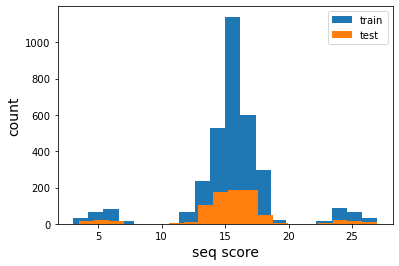

In [18]:
plot_train_test_hist(mer6motif_train_df, mer6motif_test_df,bins=20)

0 10.154756751874599
1 10.245323354151191
2 8.944285303208886
3 11.325993469284802
4 8.539987257631813
5 8.216110836005793
6 7.49009894452444
7 7.191442754210495
8 7.099442644235564
9 6.400107959421669
10 6.369677816949239
11 6.840628958911431
12 6.095117917874965
13 5.225777920571769
14 5.311041983743993
15 5.3364470749366575
16 4.684902659858145
17 4.309373957354848
18 4.107275377250299
19 3.935809838481066


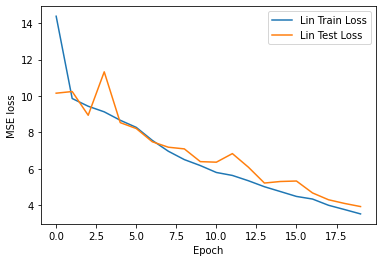

In [19]:
seq_len = len(mer6motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer6motif_model_lin = DNA_Linear(seq_len, hidden_layer_size)

mer6motif_train_losses_lin, mer6motif_test_losses_lin = u.run_model(mer6motif_train_dl, mer6motif_test_dl, mer6motif_model_lin,lr=0.01)

# to plot loss
mer6motif_lin_data_label = list(zip([mer6motif_train_losses_lin,mer6motif_test_losses_lin], ['Lin Train Loss','Lin Test Loss']))
u.quick_loss_plot(mer6motif_lin_data_label)

In [21]:
oracle_6mer_motif = scoring = dict(mer6_motif[['seq','score']].values)
quick_test(mer6motif_model_lin,oracle_6mer_motif)

AAAAAA: pred:18.679 actual:20.000 (1.321)
CCCCCC: pred:17.850 actual:17.000 (-0.850)
GGGGGG: pred:11.588 actual:14.000 (2.412)
TTTTTT: pred:13.148 actual:11.000 (-2.148)

AACCAA: pred:18.703 actual:19.000 (0.297)
CCGGGG: pred:11.564 actual:15.000 (3.436)
GGGTAA: pred:16.150 actual:15.500 (-0.650)
TTTCGT: pred:12.075 actual:12.500 (0.425)
TGTAAT: pred:15.592 actual:14.500 (-1.092)

TATAAA: pred:22.859 actual:27.000 (4.141)
CCTATC: pred:22.018 actual:25.500 (3.482)
GTATGG: pred:21.722 actual:24.000 (2.278)
TTTATT: pred:20.715 actual:22.500 (1.785)

AAGCGA: pred:10.646 actual:7.500 (-3.146)
CGCGCC: pred:7.184 actual:6.000 (-1.184)
GGGCGG: pred:8.434 actual:4.500 (-3.934)
TTGCGT: pred:5.968 actual:3.000 (-2.968)

TATGCG: pred:15.617 actual:14.500 (-1.117)
GCGTAT: pred:18.352 actual:14.500 (-3.852)



### CNN Model

0 7.016954833123742
1 4.612286193487121
2 2.7705063843145603
3 2.1451512447944503
4 1.5531316632904657
5 0.7641180066800699
6 0.4835851181207634
7 0.36165755838155744
8 0.19368066306612114
9 0.21662176001544406
10 0.2657173851186909
11 0.22659322990604291
12 0.19075170714953324
13 0.2275621276303399
14 0.14920878254286035
15 9.593947612948535
16 0.4487712045995201
17 0.16149918427690862
18 0.19747481229828626
19 0.18850655281325665


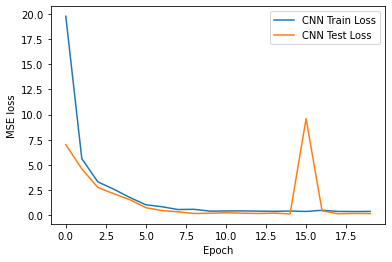

In [22]:
seq_len = len(mer6motif_train_df['seq'].values[0])

mer6motif_model_cnn = DNA_CNN(seq_len, num_filters=31,kernel_size=3)

mer6motif_train_losses_cnn, mer6motif_test_losses_cnn = u.run_model(mer6motif_train_dl, mer6motif_test_dl, mer6motif_model_cnn, lr=0.01)

# to plot loss
mer6motif_cnn_data_label = list(zip([mer6motif_train_losses_cnn,mer6motif_test_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
u.quick_loss_plot(mer6motif_cnn_data_label)

In [23]:
quick_test(mer6motif_model_cnn, oracle_6mer_motif)

AAAAAA: pred:20.242 actual:20.000 (-0.242)
CCCCCC: pred:16.815 actual:17.000 (0.185)
GGGGGG: pred:13.593 actual:14.000 (0.407)
TTTTTT: pred:10.980 actual:11.000 (0.020)

AACCAA: pred:18.796 actual:19.000 (0.204)
CCGGGG: pred:14.330 actual:15.000 (0.670)
GGGTAA: pred:15.654 actual:15.500 (-0.154)
TTTCGT: pred:12.535 actual:12.500 (-0.035)
TGTAAT: pred:14.605 actual:14.500 (-0.105)

TATAAA: pred:26.166 actual:27.000 (0.834)
CCTATC: pred:24.910 actual:25.500 (0.590)
GTATGG: pred:23.581 actual:24.000 (0.419)
TTTATT: pred:22.199 actual:22.500 (0.301)

AAGCGA: pred:7.277 actual:7.500 (0.223)
CGCGCC: pred:5.686 actual:6.000 (0.314)
GGGCGG: pred:4.350 actual:4.500 (0.150)
TTGCGT: pred:4.199 actual:3.000 (-1.199)

TATGCG: pred:13.763 actual:14.500 (0.737)
GCGTAT: pred:13.941 actual:14.500 (0.559)



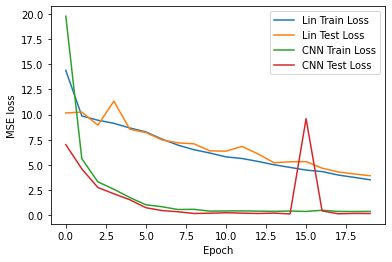

In [24]:
comb_data_label = list(zip([mer6motif_train_losses_lin,mer6motif_test_losses_lin,mer6motif_train_losses_cnn,mer6motif_test_losses_cnn], 
                          ['Lin Train Loss','Lin Test Loss','CNN Train Loss','CNN Test Loss']))

u.quick_loss_plot(comb_data_label)

# Try with 8 mers

### Single Task Regression


In [25]:
mer8_train_dl, mer8_test_dl, mer8_train_df, mer8_test_df = u.build_dataloaders_single(mer8)

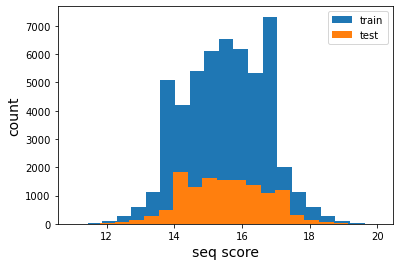

In [26]:
plot_train_test_hist(mer8_train_df, mer8_test_df,bins=20)

0 0.000726129177961752
1 0.0004862357019570417
2 0.0004082491857900324
3 0.00025905875442862206
4 0.00019965799951715283
5 0.00015830586175626126
6 0.00013513318421435648
7 0.00010671586729088775
8 8.98147360957789e-05
9 7.7158933010411e-05
10 6.727682572526179e-05
11 6.006366788928457e-05
12 5.2135043599651905e-05
13 4.7401848561686076e-05
14 4.195078401465388e-05
15 3.7838318363513584e-05
16 3.468533680655405e-05
17 3.618220135553302e-05
18 3.424234658165721e-05
19 2.6708450825849555e-05


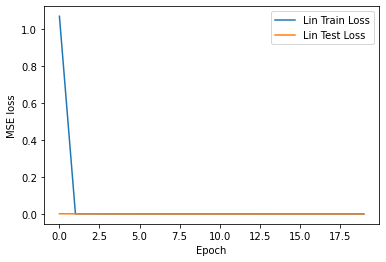

In [27]:
seq_len = len(mer8_train_df['seq'].values[0])
hidden_layer_size = 24

mer8_model_lin = DNA_Linear(seq_len, hidden_layer_size)

mer8_train_losses, mer8_test_losses = u.run_model(mer8_train_dl, mer8_test_dl, mer8_model_lin)

# to plot loss
mer8_lin_data_label = list(zip([mer8_train_losses,mer8_test_losses], ['Lin Train Loss','Lin Test Loss']))
u.quick_loss_plot(mer8_lin_data_label)

In [28]:
def quick_test8(model, oracle):
    seqs1 = ['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT']
    seqs2 = ['AACCAACA','CCGGCGCG','GGGTAAGG', 'TTTCGTTT','TGTAATAC']
    seqsTAT = ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT']
    seqsGCG = ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT']
    TATGCG =  ['ATATGCGA','TGCGTATT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        u.quick_seq_pred(model, seqs, oracle)
        print()

In [29]:
oracle_8mer = scoring = dict(mer8[['seq','score']].values)
quick_test8(mer8_model_lin, oracle_8mer)

AAAAAAAA: pred:19.993 actual:20.000 (0.007)
CCCCCCCC: pred:17.003 actual:17.000 (-0.003)
GGGGGGGG: pred:14.002 actual:14.000 (-0.002)
TTTTTTTT: pred:10.996 actual:11.000 (0.004)

AACCAACA: pred:18.877 actual:18.875 (-0.002)
CCGGCGCG: pred:15.502 actual:15.500 (-0.002)
GGGTAAGG: pred:15.131 actual:15.125 (-0.006)
TTTCGTTT: pred:12.125 actual:12.125 (-0.000)
TGTAATAC: pred:15.503 actual:15.500 (-0.003)

TATAAAAA: pred:17.742 actual:17.750 (0.008)
CCTATCCC: pred:15.877 actual:15.875 (-0.002)
GTATGGGG: pred:13.997 actual:14.000 (0.003)
TTTATTTT: pred:12.122 actual:12.125 (0.003)

AAGCGAAA: pred:18.121 actual:18.125 (0.004)
CGCGCCCC: pred:16.254 actual:16.250 (-0.004)
GGGCGGGG: pred:14.372 actual:14.375 (0.003)
TTGCGTTT: pred:12.507 actual:12.500 (-0.007)

ATATGCGA: pred:15.875 actual:15.875 (0.000)
TGCGTATT: pred:13.638 actual:13.625 (-0.013)



# Single task Regression with Motifs
### Linear Model

In [30]:
mer8motif_train_dl, \
mer8motif_test_dl, \
mer8motif_train_df, \
mer8motif_test_df = u.build_dataloaders_single(mer8_motif, batch_size=13)

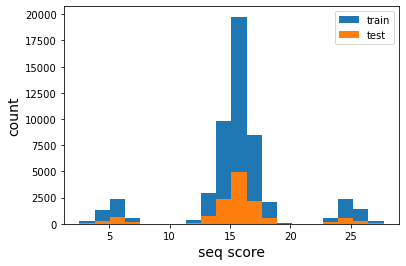

In [31]:
plot_train_test_hist(mer8motif_train_df, mer8motif_test_df,bins=20)

0 8.260702320104842
1 5.4844518438468155
2 4.439736232047842
3 3.1120423747725083
4 2.7600010337991834
5 2.2379981357380316
6 1.7781427540578492
7 1.3241797769598511
8 1.0901193777471554
9 1.3616297914998121
10 1.3738119216737568
11 0.9605638633050458
12 0.8557747881566815
13 0.9583542997112425
14 0.8168917536146673
15 0.8455398903052991
16 0.8427693262152877
17 0.8904414149964678
18 0.8240287851543371
19 1.4047848168370616


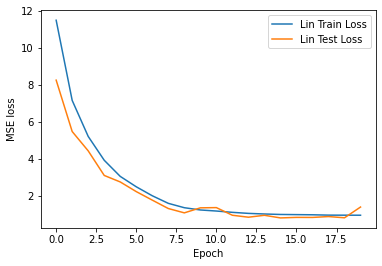

In [32]:
seq_len = len(mer8motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer8motif_model_lin = DNA_Linear(seq_len, hidden_layer_size)

mer8motif_train_losses_lin, mer8motif_test_losses_lin = u.run_model(mer8motif_train_dl, mer8motif_test_dl, mer8motif_model_lin,lr=0.01)

# to plot loss
mer8motif_lin_data_label = list(zip([mer8motif_train_losses_lin,mer8motif_test_losses_lin], ['Lin Train Loss','Lin Test Loss']))
u.quick_loss_plot(mer8motif_lin_data_label)

In [33]:
oracle_8mer_motif = scoring = dict(mer8_motif[['seq','score']].values)
quick_test8(mer8motif_model_lin,oracle_8mer_motif)

AAAAAAAA: pred:20.132 actual:20.000 (-0.132)
CCCCCCCC: pred:16.436 actual:17.000 (0.564)
GGGGGGGG: pred:13.953 actual:14.000 (0.047)
TTTTTTTT: pred:12.605 actual:11.000 (-1.605)

AACCAACA: pred:18.961 actual:18.875 (-0.086)
CCGGCGCG: pred:0.000 actual:5.500 (5.500)
GGGTAAGG: pred:15.299 actual:15.125 (-0.174)
TTTCGTTT: pred:11.649 actual:12.125 (0.476)
TGTAATAC: pred:16.355 actual:15.500 (-0.855)

TATAAAAA: pred:27.109 actual:27.750 (0.641)
CCTATCCC: pred:24.917 actual:25.875 (0.958)
GTATGGGG: pred:23.928 actual:24.000 (0.072)
TTTATTTT: pred:21.508 actual:22.125 (0.617)

AAGCGAAA: pred:6.524 actual:8.125 (1.601)
CGCGCCCC: pred:5.995 actual:6.250 (0.255)
GGGCGGGG: pred:4.135 actual:4.375 (0.240)
TTGCGTTT: pred:1.329 actual:2.500 (1.171)

ATATGCGA: pred:14.679 actual:15.875 (1.196)
TGCGTATT: pred:14.362 actual:13.625 (-0.737)



### CNN Model

0 0.48433671643405296
1 0.08431447217383953
2 0.05251995585096989
3 0.04155651001201921
4 0.06571233329527434
5 0.02284387606748874
6 0.017832015886511184
7 0.019203026113702143
8 0.01046421424433024
9 0.010137274512658188
10 0.006398916138755666
11 0.0042697711338374415
12 0.0031801531202139254
13 0.0020491528015646795
14 0.0024944196731826896
15 0.00240368363751026
16 0.0018493020463254293
17 0.0037866901664169307
18 0.002375659157561473
19 0.0019493922687337756


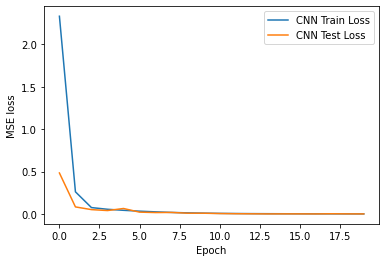

In [34]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_cnn = DNA_CNN(seq_len, num_filters=31,kernel_size=3)

mer8motif_train_losses_cnn, mer8motif_test_losses_cnn = u.run_model(mer8motif_train_dl, mer8motif_test_dl, mer8motif_model_cnn, lr=0.01)

# to plot loss
mer8motif_cnn_data_label = list(zip([mer8motif_train_losses_cnn,mer8motif_test_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
u.quick_loss_plot(mer8motif_cnn_data_label)

In [36]:
quick_test8(mer8motif_model_cnn, oracle_8mer_motif)

AAAAAAAA: pred:20.006 actual:20.000 (-0.006)
CCCCCCCC: pred:16.979 actual:17.000 (0.021)
GGGGGGGG: pred:13.995 actual:14.000 (0.005)
TTTTTTTT: pred:10.977 actual:11.000 (0.023)

AACCAACA: pred:18.847 actual:18.875 (0.028)
CCGGCGCG: pred:5.389 actual:5.500 (0.111)
GGGTAAGG: pred:15.118 actual:15.125 (0.007)
TTTCGTTT: pred:12.088 actual:12.125 (0.037)
TGTAATAC: pred:15.514 actual:15.500 (-0.014)

TATAAAAA: pred:27.644 actual:27.750 (0.106)
CCTATCCC: pred:25.901 actual:25.875 (-0.026)
GTATGGGG: pred:23.974 actual:24.000 (0.026)
TTTATTTT: pred:22.039 actual:22.125 (0.086)

AAGCGAAA: pred:8.082 actual:8.125 (0.043)
CGCGCCCC: pred:6.218 actual:6.250 (0.032)
GGGCGGGG: pred:4.319 actual:4.375 (0.056)
TTGCGTTT: pred:2.423 actual:2.500 (0.077)

ATATGCGA: pred:15.708 actual:15.875 (0.167)
TGCGTATT: pred:13.850 actual:13.625 (-0.225)



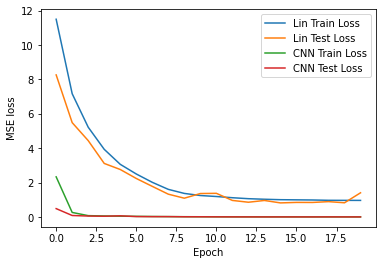

In [37]:
comb_data_label = list(zip([mer8motif_train_losses_lin,mer8motif_test_losses_lin,mer8motif_train_losses_cnn,mer8motif_test_losses_cnn], 
                          ['Lin Train Loss','Lin Test Loss','CNN Train Loss','CNN Test Loss']))

u.quick_loss_plot(comb_data_label)

# inspect

### 6mer model

In [38]:
mer6motif_model_cnn

DNA_CNN(
  (conv_net): Sequential(
    (0): Conv1d(4, 31, kernel_size=(3,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=124, out_features=10, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [39]:
conv_layers, model_weights, bias_weights = u.get_conv_layers_from_model(mer6motif_model_cnn)

Total convolutional layers: 1


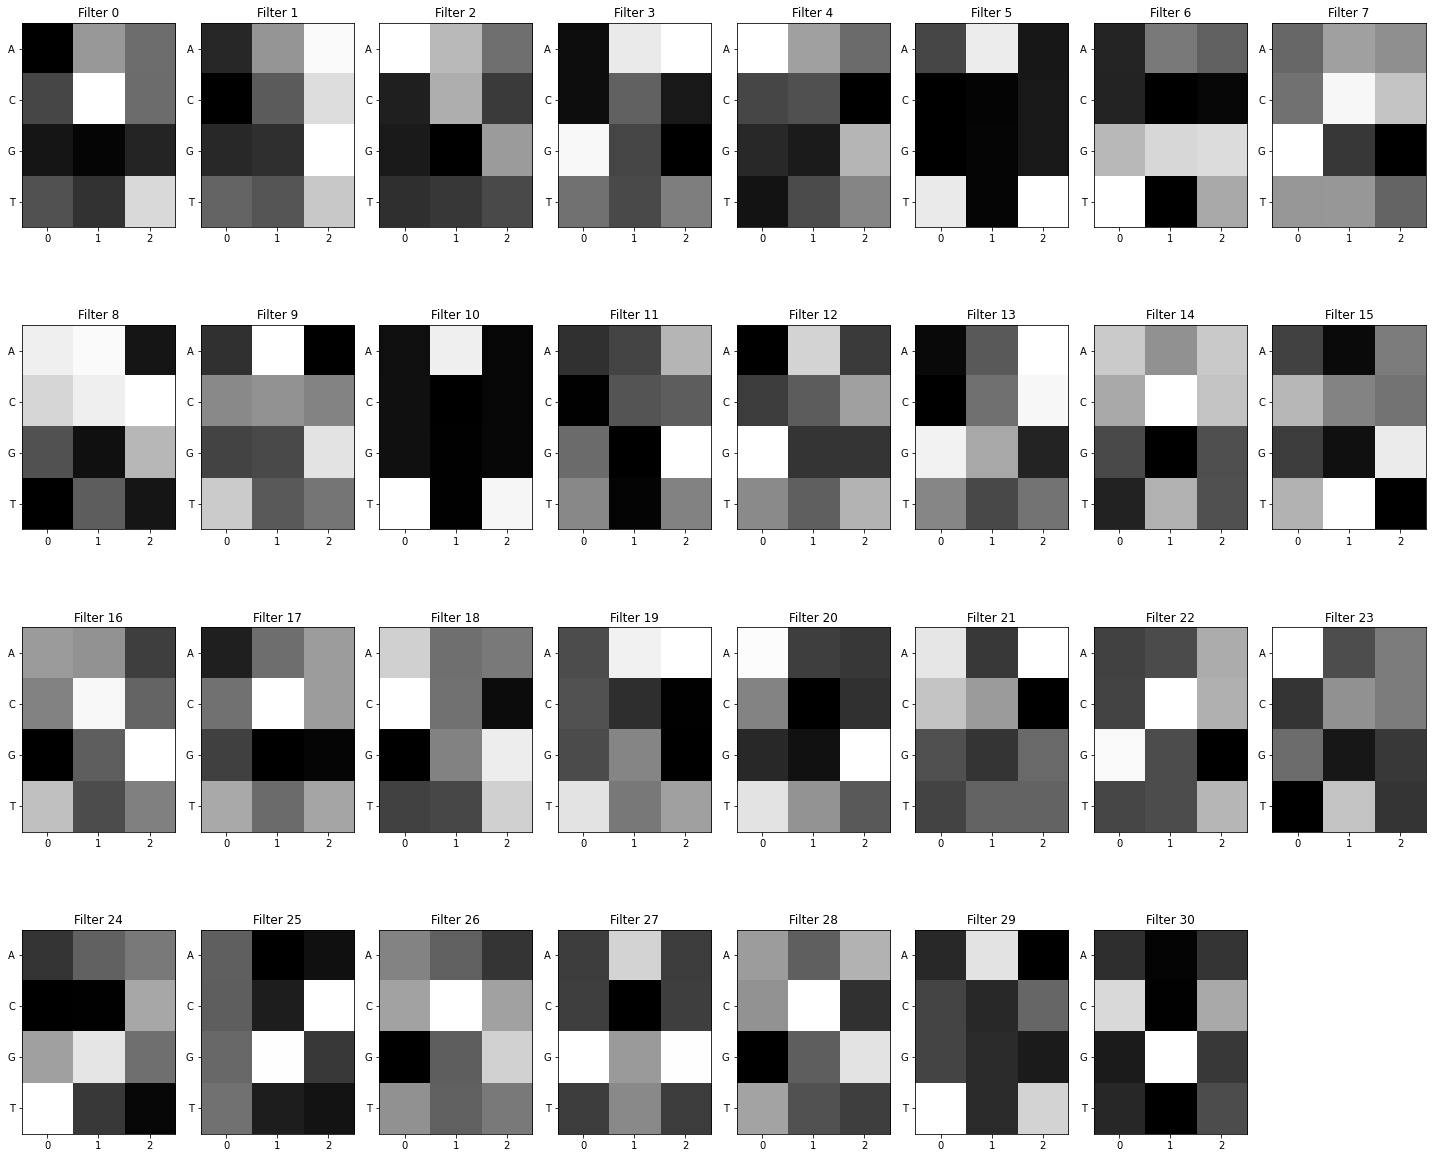

In [40]:
u.view_filters(model_weights)

In [41]:
train_seqs = list(mer6motif_train_df['seq'])
filter_activations = u.get_filter_activations(train_seqs, conv_layers[0])

Running seq AAAAAA
Running seq AAAAAC
Running seq AAAAAG
Running seq AAAAAT
Running seq AAAACA
Running seq AAAACG
Running seq AAAACT
Running seq AAAAGA
Running seq AAAAGC
Running seq AAAAGG
Running seq AAAAGT
Running seq AAAATA
Running seq AAAATC
Running seq AAAATG
Running seq AAAATT
Running seq AAACAA
Running seq AAACAG
Running seq AAACAT
Running seq AAACCA
Running seq AAACCC
Running seq AAACCG
Running seq AAACCT
Running seq AAACGG
Running seq AAACTA
Running seq AAACTC
Running seq AAACTG
Running seq AAACTT
Running seq AAAGAA
Running seq AAAGAG
Running seq AAAGAT
Running seq AAAGCC
Running seq AAAGCG
Running seq AAAGCT
Running seq AAAGGA
Running seq AAAGGG
Running seq AAAGGT
Running seq AAAGTA
Running seq AAAGTC
Running seq AAAGTT
Running seq AAATAC
Running seq AAATAG
Running seq AAATAT
Running seq AAATCA
Running seq AAATCC
Running seq AAATCT
Running seq AAATGA
Running seq AAATGC
Running seq AAATGG
Running seq AAATGT
Running seq AAATTA
Running seq AAATTC
Running seq AAATTG
Running seq 

Running seq AGATCG
Running seq AGATCT
Running seq AGATGC
Running seq AGATGG
Running seq AGATGT
Running seq AGATTA
Running seq AGATTC
Running seq AGATTG
Running seq AGATTT
Running seq AGCAAG
Running seq AGCAAT
Running seq AGCACC
Running seq AGCACG
Running seq AGCACT
Running seq AGCAGA
Running seq AGCAGC
Running seq AGCAGG
Running seq AGCAGT
Running seq AGCATC
Running seq AGCATT
Running seq AGCCAA
Running seq AGCCAG
Running seq AGCCAT
Running seq AGCCCA
Running seq AGCCCC
Running seq AGCCCG
Running seq AGCCGA
Running seq AGCCGC
Running seq AGCCGT
Running seq AGCCTA
Running seq AGCCTC
Running seq AGCCTG
Running seq AGCCTT
Running seq AGCGAA
Running seq AGCGAC
Running seq AGCGAG
Running seq AGCGAT
Running seq AGCGCT
Running seq AGCGGA
Running seq AGCGGC
Running seq AGCGGT
Running seq AGCGTA
Running seq AGCGTC
Running seq AGCGTG
Running seq AGCTAA
Running seq AGCTAG
Running seq AGCTAT
Running seq AGCTCA
Running seq AGCTCC
Running seq AGCTCG
Running seq AGCTCT
Running seq AGCTGA
Running seq 

Running seq CACTCA
Running seq CACTCC
Running seq CACTCG
Running seq CACTCT
Running seq CACTGA
Running seq CACTGC
Running seq CACTGG
Running seq CACTGT
Running seq CACTTA
Running seq CACTTC
Running seq CACTTG
Running seq CACTTT
Running seq CAGAAC
Running seq CAGAAT
Running seq CAGACA
Running seq CAGACC
Running seq CAGACG
Running seq CAGACT
Running seq CAGAGA
Running seq CAGAGC
Running seq CAGAGG
Running seq CAGAGT
Running seq CAGATA
Running seq CAGATG
Running seq CAGATT
Running seq CAGCAA
Running seq CAGCAG
Running seq CAGCAT
Running seq CAGCCC
Running seq CAGCGA
Running seq CAGCGC
Running seq CAGCGG
Running seq CAGCGT
Running seq CAGCTA
Running seq CAGCTC
Running seq CAGCTG
Running seq CAGCTT
Running seq CAGGAC
Running seq CAGGAG
Running seq CAGGAT
Running seq CAGGCA
Running seq CAGGCG
Running seq CAGGCT
Running seq CAGGGA
Running seq CAGGGC
Running seq CAGGGG
Running seq CAGGGT
Running seq CAGGTA
Running seq CAGGTC
Running seq CAGGTT
Running seq CAGTAA
Running seq CAGTAC
Running seq 

Running seq CGGCCT
Running seq CGGCGC
Running seq CGGCGG
Running seq CGGCGT
Running seq CGGCTA
Running seq CGGCTC
Running seq CGGCTG
Running seq CGGCTT
Running seq CGGGAA
Running seq CGGGAG
Running seq CGGGAT
Running seq CGGGCA
Running seq CGGGCT
Running seq CGGGGA
Running seq CGGGGG
Running seq CGGGTA
Running seq CGGGTC
Running seq CGGGTG
Running seq CGGGTT
Running seq CGGTAA
Running seq CGGTAC
Running seq CGGTAG
Running seq CGGTAT
Running seq CGGTCA
Running seq CGGTCC
Running seq CGGTCG
Running seq CGGTCT
Running seq CGGTGC
Running seq CGGTGG
Running seq CGGTGT
Running seq CGGTTC
Running seq CGTAAC
Running seq CGTAAG
Running seq CGTACA
Running seq CGTACC
Running seq CGTACT
Running seq CGTAGA
Running seq CGTAGC
Running seq CGTAGG
Running seq CGTAGT
Running seq CGTATC
Running seq CGTATT
Running seq CGTCAA
Running seq CGTCAC
Running seq CGTCAG
Running seq CGTCAT
Running seq CGTCCA
Running seq CGTCCC
Running seq CGTCCG
Running seq CGTCCT
Running seq CGTCGA
Running seq CGTCGC
Running seq 

Running seq GATATC
Running seq GATATG
Running seq GATATT
Running seq GATCAT
Running seq GATCCA
Running seq GATCCC
Running seq GATCCG
Running seq GATCCT
Running seq GATCGA
Running seq GATCGT
Running seq GATCTA
Running seq GATCTC
Running seq GATCTG
Running seq GATCTT
Running seq GATGAA
Running seq GATGAC
Running seq GATGAG
Running seq GATGCA
Running seq GATGCC
Running seq GATGCG
Running seq GATGCT
Running seq GATGGC
Running seq GATGGG
Running seq GATGTA
Running seq GATGTC
Running seq GATGTG
Running seq GATGTT
Running seq GATTAA
Running seq GATTAC
Running seq GATTAT
Running seq GATTCA
Running seq GATTCC
Running seq GATTCG
Running seq GATTCT
Running seq GATTGA
Running seq GATTGC
Running seq GATTGT
Running seq GATTTA
Running seq GATTTC
Running seq GATTTG
Running seq GATTTT
Running seq GCAAAA
Running seq GCAAAC
Running seq GCAAAT
Running seq GCAACA
Running seq GCAACC
Running seq GCAACG
Running seq GCAACT
Running seq GCAAGA
Running seq GCAAGC
Running seq GCAAGG
Running seq GCAAGT
Running seq 

Running seq GTACCT
Running seq GTACGC
Running seq GTACGG
Running seq GTACGT
Running seq GTACTA
Running seq GTACTC
Running seq GTACTG
Running seq GTACTT
Running seq GTAGAA
Running seq GTAGAG
Running seq GTAGAT
Running seq GTAGCA
Running seq GTAGCC
Running seq GTAGCT
Running seq GTAGGA
Running seq GTAGGG
Running seq GTAGGT
Running seq GTAGTA
Running seq GTAGTC
Running seq GTAGTG
Running seq GTAGTT
Running seq GTATAA
Running seq GTATAC
Running seq GTATAG
Running seq GTATAT
Running seq GTATCA
Running seq GTATCC
Running seq GTATCG
Running seq GTATCT
Running seq GTATGA
Running seq GTATGC
Running seq GTATGG
Running seq GTATGT
Running seq GTATTA
Running seq GTATTC
Running seq GTATTG
Running seq GTATTT
Running seq GTCAAC
Running seq GTCAAG
Running seq GTCAAT
Running seq GTCACA
Running seq GTCACC
Running seq GTCACG
Running seq GTCACT
Running seq GTCAGA
Running seq GTCAGC
Running seq GTCAGG
Running seq GTCAGT
Running seq GTCATA
Running seq GTCATC
Running seq GTCATG
Running seq GTCATT
Running seq 

Running seq TCAGTC
Running seq TCAGTG
Running seq TCAGTT
Running seq TCATAA
Running seq TCATAC
Running seq TCATAT
Running seq TCATCA
Running seq TCATCT
Running seq TCATGC
Running seq TCATGG
Running seq TCATTA
Running seq TCATTC
Running seq TCATTG
Running seq TCATTT
Running seq TCCAAA
Running seq TCCAAC
Running seq TCCAAG
Running seq TCCAAT
Running seq TCCACA
Running seq TCCACC
Running seq TCCACG
Running seq TCCAGA
Running seq TCCAGC
Running seq TCCAGG
Running seq TCCAGT
Running seq TCCATA
Running seq TCCATC
Running seq TCCATG
Running seq TCCCAC
Running seq TCCCCA
Running seq TCCCCC
Running seq TCCCCG
Running seq TCCCCT
Running seq TCCCGC
Running seq TCCCGG
Running seq TCCCTA
Running seq TCCCTC
Running seq TCCCTG
Running seq TCCCTT
Running seq TCCGAA
Running seq TCCGAG
Running seq TCCGCA
Running seq TCCGCC
Running seq TCCGCG
Running seq TCCGGA
Running seq TCCGGC
Running seq TCCGGG
Running seq TCCGGT
Running seq TCCGTA
Running seq TCCGTC
Running seq TCCGTG
Running seq TCCGTT
Running seq 

Running seq TTCGAA
Running seq TTCGAG
Running seq TTCGCC
Running seq TTCGCG
Running seq TTCGCT
Running seq TTCGGA
Running seq TTCGGC
Running seq TTCGGG
Running seq TTCGGT
Running seq TTCGTA
Running seq TTCGTC
Running seq TTCGTG
Running seq TTCGTT
Running seq TTCTAA
Running seq TTCTAC
Running seq TTCTAG
Running seq TTCTAT
Running seq TTCTCA
Running seq TTCTCC
Running seq TTCTCG
Running seq TTCTCT
Running seq TTCTGA
Running seq TTCTGC
Running seq TTCTGT
Running seq TTCTTA
Running seq TTCTTG
Running seq TTCTTT
Running seq TTGAAA
Running seq TTGAAC
Running seq TTGAAG
Running seq TTGAAT
Running seq TTGACC
Running seq TTGACG
Running seq TTGACT
Running seq TTGAGA
Running seq TTGAGC
Running seq TTGAGG
Running seq TTGAGT
Running seq TTGATA
Running seq TTGATC
Running seq TTGATT
Running seq TTGCAA
Running seq TTGCAC
Running seq TTGCAG
Running seq TTGCAT
Running seq TTGCCA
Running seq TTGCCC
Running seq TTGCCT
Running seq TTGCGA
Running seq TTGCGT
Running seq TTGCTC
Running seq TTGCTG
Running seq 

/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


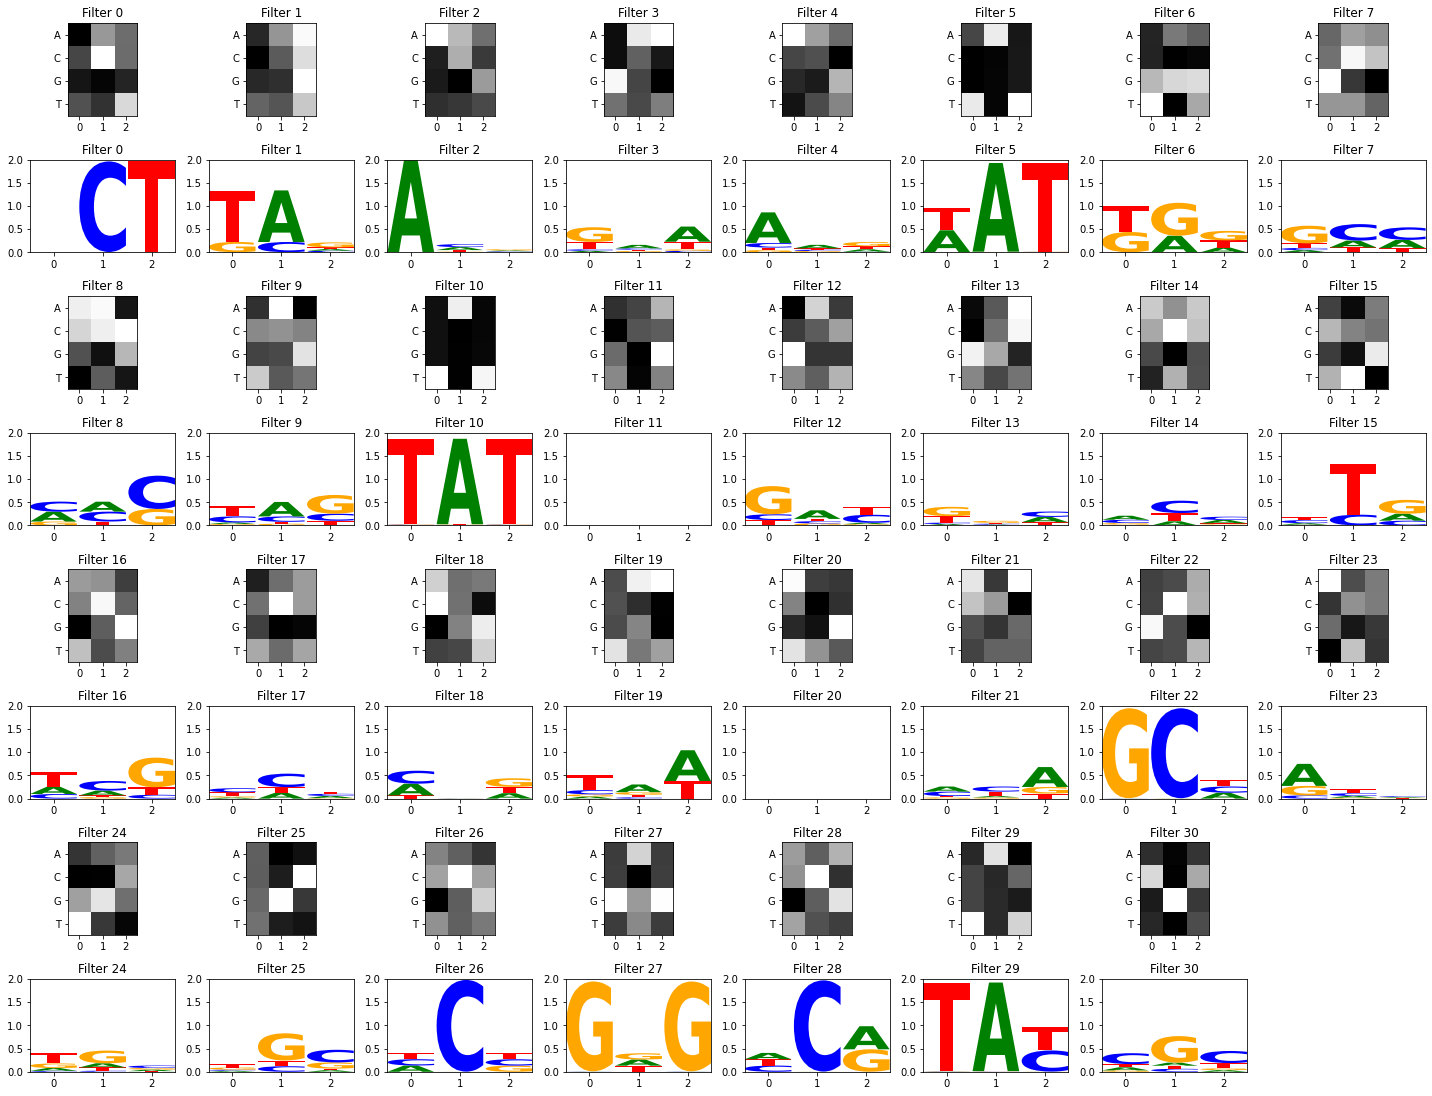

In [42]:
u.view_filters_and_logos(model_weights,filter_activations)

# 8mer model cnn

Total convolutional layers: 1


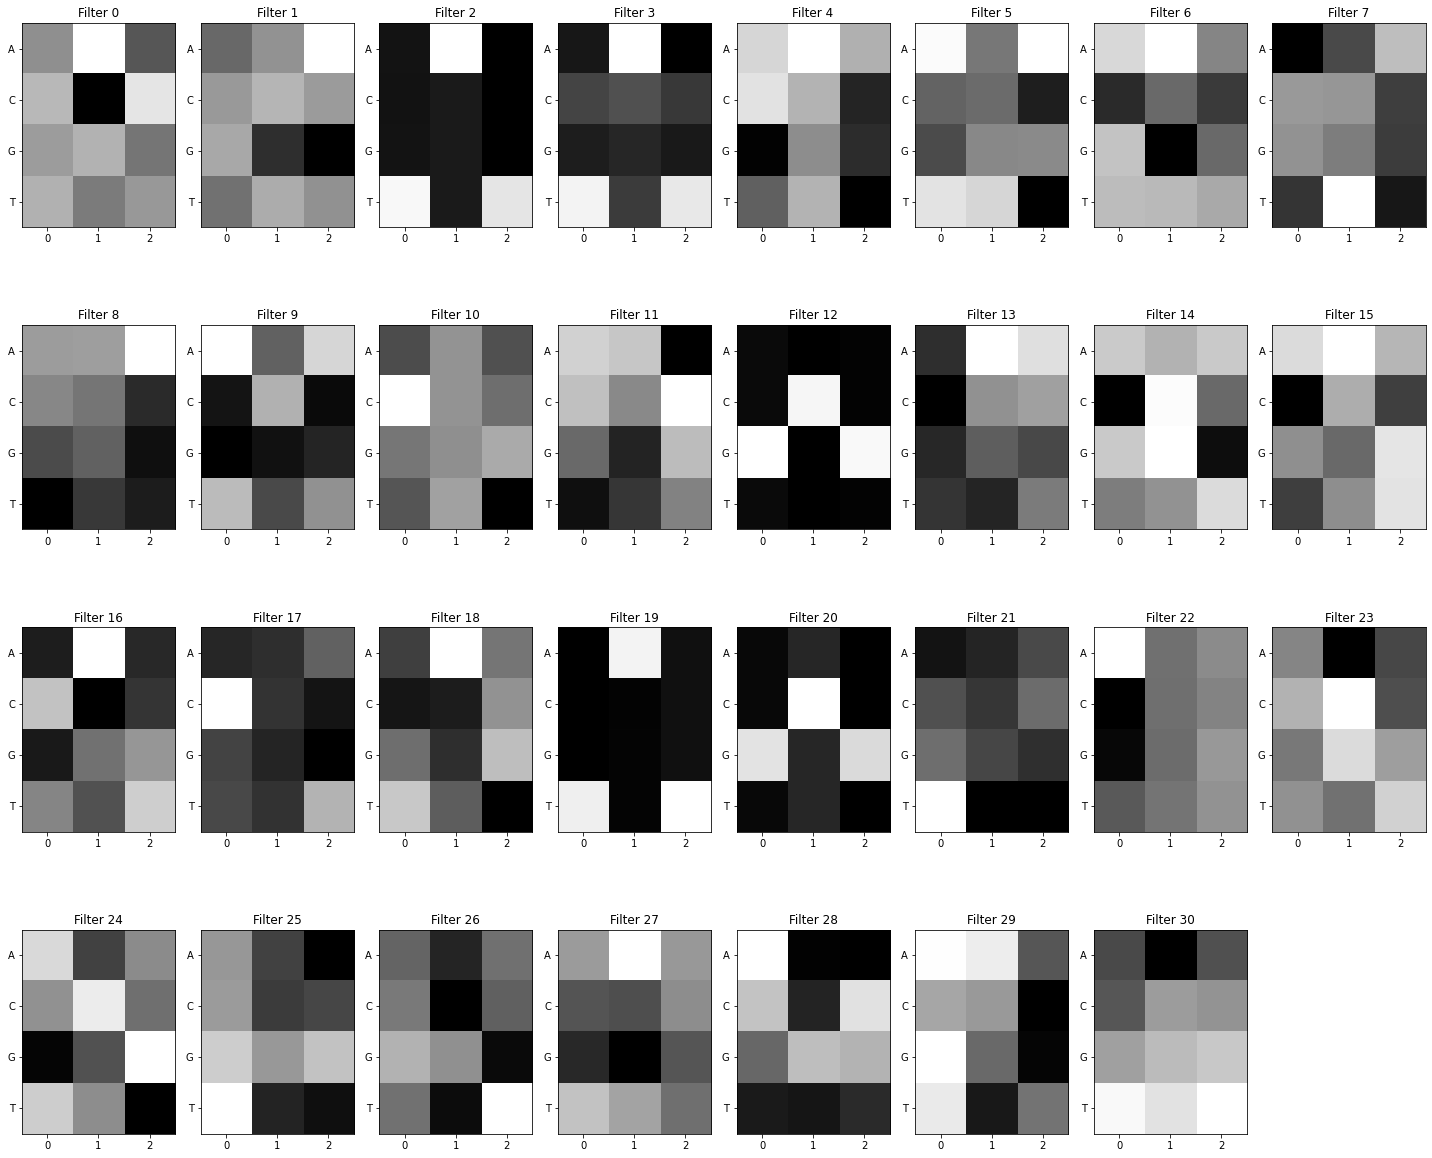

In [43]:
conv_layers, model_weights, bias_weights = u.get_conv_layers_from_model(mer8motif_model_cnn)
u.view_filters(model_weights)

In [44]:
train_seqs = list(mer6motif_train_df['seq'])# still using mer6 seqs is ok cuz just getting activations!
filter_activations = u.get_filter_activations(train_seqs, conv_layers[0])

Running seq AAAAAA
Running seq AAAAAC
Running seq AAAAAG
Running seq AAAAAT
Running seq AAAACA
Running seq AAAACG
Running seq AAAACT
Running seq AAAAGA
Running seq AAAAGC
Running seq AAAAGG
Running seq AAAAGT
Running seq AAAATA
Running seq AAAATC
Running seq AAAATG
Running seq AAAATT
Running seq AAACAA
Running seq AAACAG
Running seq AAACAT
Running seq AAACCA
Running seq AAACCC
Running seq AAACCG
Running seq AAACCT
Running seq AAACGG
Running seq AAACTA
Running seq AAACTC
Running seq AAACTG
Running seq AAACTT
Running seq AAAGAA
Running seq AAAGAG
Running seq AAAGAT
Running seq AAAGCC
Running seq AAAGCG
Running seq AAAGCT
Running seq AAAGGA
Running seq AAAGGG
Running seq AAAGGT
Running seq AAAGTA
Running seq AAAGTC
Running seq AAAGTT
Running seq AAATAC
Running seq AAATAG
Running seq AAATAT
Running seq AAATCA
Running seq AAATCC
Running seq AAATCT
Running seq AAATGA
Running seq AAATGC
Running seq AAATGG
Running seq AAATGT
Running seq AAATTA
Running seq AAATTC
Running seq AAATTG
Running seq 

Running seq AGCCGA
Running seq AGCCGC
Running seq AGCCGT
Running seq AGCCTA
Running seq AGCCTC
Running seq AGCCTG
Running seq AGCCTT
Running seq AGCGAA
Running seq AGCGAC
Running seq AGCGAG
Running seq AGCGAT
Running seq AGCGCT
Running seq AGCGGA
Running seq AGCGGC
Running seq AGCGGT
Running seq AGCGTA
Running seq AGCGTC
Running seq AGCGTG
Running seq AGCTAA
Running seq AGCTAG
Running seq AGCTAT
Running seq AGCTCA
Running seq AGCTCC
Running seq AGCTCG
Running seq AGCTCT
Running seq AGCTGA
Running seq AGCTGT
Running seq AGCTTA
Running seq AGCTTC
Running seq AGCTTG
Running seq AGCTTT
Running seq AGGAAA
Running seq AGGAAC
Running seq AGGAAG
Running seq AGGAAT
Running seq AGGACA
Running seq AGGACC
Running seq AGGACG
Running seq AGGACT
Running seq AGGAGA
Running seq AGGAGC
Running seq AGGAGG
Running seq AGGAGT
Running seq AGGATA
Running seq AGGATC
Running seq AGGATG
Running seq AGGATT
Running seq AGGCAA
Running seq AGGCAG
Running seq AGGCCC
Running seq AGGCCT
Running seq AGGCGA
Running seq 

Running seq CAGATG
Running seq CAGATT
Running seq CAGCAA
Running seq CAGCAG
Running seq CAGCAT
Running seq CAGCCC
Running seq CAGCGA
Running seq CAGCGC
Running seq CAGCGG
Running seq CAGCGT
Running seq CAGCTA
Running seq CAGCTC
Running seq CAGCTG
Running seq CAGCTT
Running seq CAGGAC
Running seq CAGGAG
Running seq CAGGAT
Running seq CAGGCA
Running seq CAGGCG
Running seq CAGGCT
Running seq CAGGGA
Running seq CAGGGC
Running seq CAGGGG
Running seq CAGGGT
Running seq CAGGTA
Running seq CAGGTC
Running seq CAGGTT
Running seq CAGTAA
Running seq CAGTAC
Running seq CAGTAG
Running seq CAGTAT
Running seq CAGTCC
Running seq CAGTCG
Running seq CAGTCT
Running seq CAGTGC
Running seq CAGTGG
Running seq CAGTGT
Running seq CAGTTA
Running seq CAGTTC
Running seq CAGTTG
Running seq CAGTTT
Running seq CATAAA
Running seq CATAAG
Running seq CATAAT
Running seq CATACA
Running seq CATACC
Running seq CATACG
Running seq CATACT
Running seq CATAGA
Running seq CATAGC
Running seq CATAGG
Running seq CATAGT
Running seq 

Running seq CGTCAA
Running seq CGTCAC
Running seq CGTCAG
Running seq CGTCAT
Running seq CGTCCA
Running seq CGTCCC
Running seq CGTCCG
Running seq CGTCCT
Running seq CGTCGA
Running seq CGTCGC
Running seq CGTCGG
Running seq CGTCGT
Running seq CGTCTA
Running seq CGTCTG
Running seq CGTGAA
Running seq CGTGAG
Running seq CGTGAT
Running seq CGTGCA
Running seq CGTGCC
Running seq CGTGCG
Running seq CGTGCT
Running seq CGTGGA
Running seq CGTGGC
Running seq CGTGGG
Running seq CGTGGT
Running seq CGTGTA
Running seq CGTGTC
Running seq CGTGTG
Running seq CGTGTT
Running seq CGTTAA
Running seq CGTTAC
Running seq CGTTAG
Running seq CGTTAT
Running seq CGTTCA
Running seq CGTTCC
Running seq CGTTCG
Running seq CGTTCT
Running seq CGTTGA
Running seq CGTTGC
Running seq CGTTGG
Running seq CGTTGT
Running seq CGTTTA
Running seq CGTTTC
Running seq CGTTTG
Running seq CGTTTT
Running seq CTAAAA
Running seq CTAAAC
Running seq CTAACC
Running seq CTAACG
Running seq CTAAGA
Running seq CTAAGC
Running seq CTAAGG
Running seq 

Running seq GCAGAA
Running seq GCAGAC
Running seq GCAGAT
Running seq GCAGCC
Running seq GCAGCG
Running seq GCAGCT
Running seq GCAGGA
Running seq GCAGGC
Running seq GCAGGT
Running seq GCAGTA
Running seq GCAGTC
Running seq GCAGTG
Running seq GCAGTT
Running seq GCATAA
Running seq GCATAC
Running seq GCATAT
Running seq GCATCC
Running seq GCATCG
Running seq GCATCT
Running seq GCATGC
Running seq GCATGT
Running seq GCATTA
Running seq GCATTC
Running seq GCATTG
Running seq GCCAAC
Running seq GCCAAG
Running seq GCCAAT
Running seq GCCACA
Running seq GCCACG
Running seq GCCAGA
Running seq GCCAGC
Running seq GCCAGG
Running seq GCCATA
Running seq GCCATC
Running seq GCCATG
Running seq GCCATT
Running seq GCCCAA
Running seq GCCCAC
Running seq GCCCAG
Running seq GCCCAT
Running seq GCCCCA
Running seq GCCCCC
Running seq GCCCCG
Running seq GCCCCT
Running seq GCCCGA
Running seq GCCCGC
Running seq GCCCGG
Running seq GCCCTA
Running seq GCCCTC
Running seq GCCCTG
Running seq GCCGAC
Running seq GCCGAG
Running seq 

Running seq GTCGTG
Running seq GTCGTT
Running seq GTCTAA
Running seq GTCTAG
Running seq GTCTAT
Running seq GTCTCA
Running seq GTCTCC
Running seq GTCTCG
Running seq GTCTCT
Running seq GTCTGA
Running seq GTCTGC
Running seq GTCTGG
Running seq GTCTTA
Running seq GTCTTC
Running seq GTCTTT
Running seq GTGAAA
Running seq GTGAAG
Running seq GTGAAT
Running seq GTGACC
Running seq GTGACG
Running seq GTGACT
Running seq GTGAGA
Running seq GTGAGC
Running seq GTGAGG
Running seq GTGAGT
Running seq GTGATA
Running seq GTGATC
Running seq GTGATG
Running seq GTGATT
Running seq GTGCCA
Running seq GTGCCC
Running seq GTGCCG
Running seq GTGCGA
Running seq GTGCGC
Running seq GTGCGG
Running seq GTGCGT
Running seq GTGCTA
Running seq GTGCTC
Running seq GTGCTG
Running seq GTGCTT
Running seq GTGGAA
Running seq GTGGAC
Running seq GTGGAG
Running seq GTGGAT
Running seq GTGGCA
Running seq GTGGCC
Running seq GTGGCG
Running seq GTGGGA
Running seq GTGGGC
Running seq GTGGGT
Running seq GTGGTA
Running seq GTGGTC
Running seq 

Running seq TCGTTT
Running seq TCTAAA
Running seq TCTAAG
Running seq TCTAAT
Running seq TCTACA
Running seq TCTACC
Running seq TCTACG
Running seq TCTACT
Running seq TCTAGA
Running seq TCTAGG
Running seq TCTAGT
Running seq TCTATA
Running seq TCTATC
Running seq TCTATG
Running seq TCTATT
Running seq TCTCAA
Running seq TCTCAC
Running seq TCTCAG
Running seq TCTCAT
Running seq TCTCCA
Running seq TCTCCC
Running seq TCTCCG
Running seq TCTCCT
Running seq TCTCGC
Running seq TCTCGT
Running seq TCTCTA
Running seq TCTCTC
Running seq TCTCTG
Running seq TCTCTT
Running seq TCTGAG
Running seq TCTGAT
Running seq TCTGCC
Running seq TCTGCG
Running seq TCTGCT
Running seq TCTGGA
Running seq TCTGGG
Running seq TCTGGT
Running seq TCTGTA
Running seq TCTGTC
Running seq TCTGTG
Running seq TCTGTT
Running seq TCTTAC
Running seq TCTTAG
Running seq TCTTCA
Running seq TCTTCG
Running seq TCTTCT
Running seq TCTTGA
Running seq TCTTGC
Running seq TCTTGG
Running seq TCTTGT
Running seq TCTTTA
Running seq TCTTTC
Running seq 

Running seq TTTCAC
Running seq TTTCAG
Running seq TTTCAT
Running seq TTTCCA
Running seq TTTCCG
Running seq TTTCCT
Running seq TTTCGA
Running seq TTTCGC
Running seq TTTCGG
Running seq TTTCGT
Running seq TTTCTA
Running seq TTTCTG
Running seq TTTCTT
Running seq TTTGAC
Running seq TTTGAG
Running seq TTTGCA
Running seq TTTGCC
Running seq TTTGCG
Running seq TTTGGA
Running seq TTTGGC
Running seq TTTGGG
Running seq TTTGGT
Running seq TTTGTA
Running seq TTTGTC
Running seq TTTGTG
Running seq TTTTAA
Running seq TTTTAG
Running seq TTTTAT
Running seq TTTTCA
Running seq TTTTCC
Running seq TTTTCT
Running seq TTTTGA
Running seq TTTTGC
Running seq TTTTGG
Running seq TTTTTA
Running seq TTTTTC
Running seq TTTTTG
Running seq TTTTTT


/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/hom

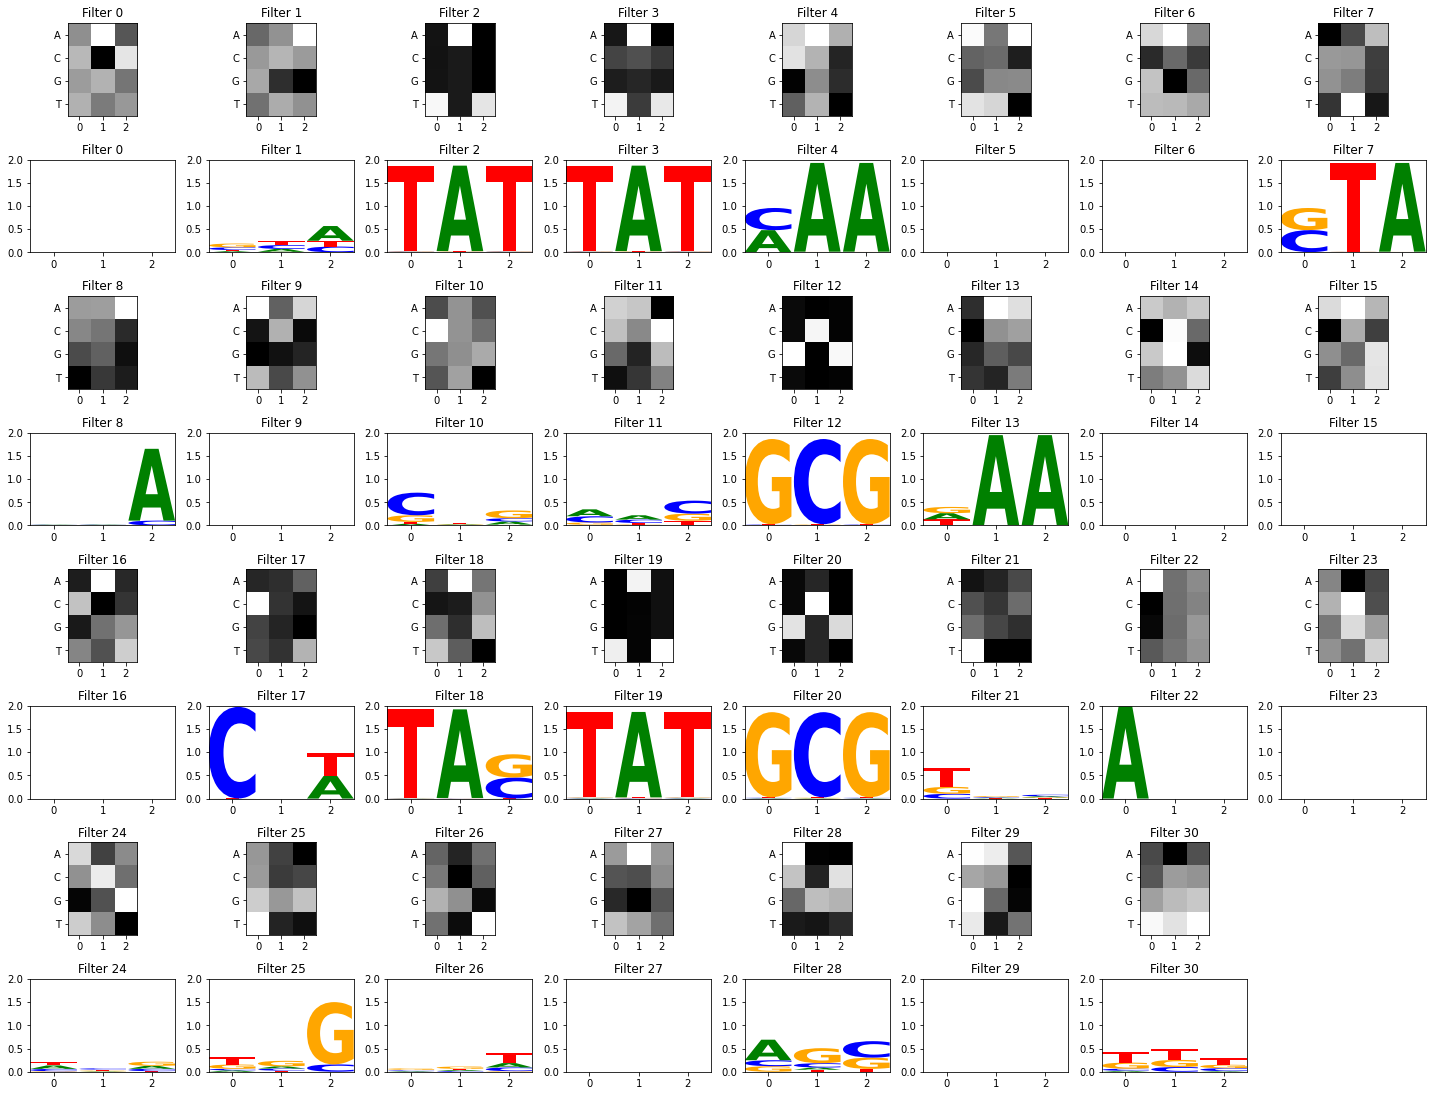

In [45]:
u.view_filters_and_logos(model_weights,filter_activations)

# Try LSTMs

In [46]:
mer8motif_train_dl,\
mer8motif_test_dl, \
mer8motif_train_df, \
mer8motif_test_df = u.build_dataloaders_single(mer8_motif,batch_size=11)
# change to batch size 11 so I can figure out the dimension errors

In [47]:
# class DNA_LSTM(nn.Module):
#     def __init__(self,
#                  seq_len,
#                  hidden_dim=10,
#                  layer1_dim=12,
#                  #layer2_dim=12
#                 ):
#         super().__init__()
#         self.seq_len = seq_len
#         self.hidden_dim = hidden_dim
        
#         self.hidden_init_values = None
#         self.hidden = self.init_hidden() # tuple of hidden state and cell state
        
#         self.rnn = nn.LSTM(4, hidden_dim,batch_first=True)
# #         self.fc = nn.Sequential(
# #             nn.ReLU(inplace=True),
# #             #nn.Flatten(),
# #             nn.Linear(hidden_dim, layer1_dim),
# #             nn.ReLU(inplace=True),
# #             nn.Linear(layer1_dim, 1),
# #         )
#         self.fc = nn.Linear(hidden_dim, 1)
            
# #         self.rnn = nn.Sequential(
# #             nn.LSTM(4, hidden_dim),
# #             nn.ReLU(inplace=True),
# #             nn.Flatten(),
# #             nn.Linear(hidden_dim, layer1_dim),
# #             nn.ReLU(inplace=True),
# #             nn.Linear(layer1_dim, 1),
# #         ) 
    
#     def init_hidden(self):
#         if self.hidden_init_values == None:
#             self.hidden_init_values = (autograd.Variable(torch.randn(1, 1, self.hidden_dim)),
#                                        autograd.Variable(torch.randn(1, 1, self.hidden_dim)))
#         return self.hidden_init_values
#         #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
    

#     def forward(self, xb):
#         # WRONG? reshape view to batch_ssize x 4channel x seq_len
#         # for LSTM? reshape view to seq_len x batch_ssize x 4channel  
#         # permute to put channel in correct order
#         print("original xb.shape:", xb.shape)
#         print(xb)
#         xb = xb.view(-1,self.seq_len,4)#.permute(1,0,2) 
#         print("re-viewed xb.shape:", xb.shape) # >> 11, 8, 4
#         print(xb)
#         #print(xb[0])
#         #print("xb shape", xb.shape)

#         # ** Init hidden temp **
#         batch_size = xb.shape[0]
#         print("batch_size:",batch_size)
#         (h, c) =  (torch.zeros(1, batch_size, self.hidden_dim), torch.zeros(1, batch_size, self.hidden_dim)) 
#         # *******
        
#         lstm_out, self.hidden = self.rnn(xb, (h,c)) # should this get H and C?
#         print("lstm_out",lstm_out)
#         print("^^^^^lstm_out shape:",lstm_out.shape) # >> 11, 8, 10
#         print("lstm_out[-1] shape:",lstm_out[-1].shape)
#         print("lstm_out[-1][-1] shape:",lstm_out[-1][-1].shape)
#         print("hidden len:",len(self.hidden))
#         print("hidden[0] shape:", self.hidden[0].shape)
#         print("hidden[0][-1] shape:", self.hidden[0][-1].shape)
#         print("hidden[0][-1][-1] shape:", self.hidden[0][-1][-1].shape)
        
#         print("*****")
#         A = lstm_out[-1][-1]
#         B = self.hidden[0][-1][-1]
#         print("lstm_out[-1][-1]:",A)
#         print("self.hidden[0][-1][-1]",B)
#         print("==?", A==B)
#         print("*****")
        
#         #linear_in = lstm_out.contiguous().view(-1, self.hidden_dim)
#         #print("Linear In shape:", linear_in.shape)
#         #print("self.hidden",self.hidden)
#         #print(self.hidden[1].shape)
#         #out = self.fc(linear_in)
#         out = self.fc(lstm_out)
#         #print("out",out)
#         print("LSTM->FC out shape:",out.shape)
#         return out

In [48]:
class DNA_LSTM(nn.Module):
    def __init__(self,seq_len,hidden_dim=10):
        super().__init__()
        self.seq_len = seq_len

        self.hidden_dim = hidden_dim
        self.hidden = None # when initialized, should be tuple of (hidden state, cell state)
        
        self.rnn = nn.LSTM(4, hidden_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
            

    
    def init_hidden(self,batch_size):
        # initialize hidden and cell states with 0s
        self.hidden =  (torch.zeros(1, batch_size, self.hidden_dim), 
                        torch.zeros(1, batch_size, self.hidden_dim))
        return self.hidden
        #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
    

    def forward(self, xb,verbose=False):
        if verbose:
            print("original xb.shape:", xb.shape)
            print(xb) # 11 x 32
        
        # make the one-hot nucleotide vectors group together
        xb = xb.view(-1,self.seq_len,4) 
        if verbose:
            print("re-viewed xb.shape:", xb.shape) # >> 11 x 8 x 4
            print(xb)

        # ** Init hidden/cell states?? **
        batch_size = xb.shape[0]
        if verbose:
            print("batch_size:",batch_size)
        (h,c) = self.init_hidden(batch_size)
         
        # *******
        
        lstm_out, self.hidden = self.rnn(xb, (h,c)) # should this get H and C?
        if verbose:
            #print("lstm_out",lstm_out)
            print("lstm_out shape:",lstm_out.shape) # >> 11, 8, 10
            print("lstm_out[-1] shape:",lstm_out[-1].shape) # >> 8 x 10
            print("lstm_out[-1][-1] shape:",lstm_out[-1][-1].shape) # 10

            print("hidden len:",len(self.hidden)) # 2
            print("hidden[0] shape:", self.hidden[0].shape) # >> 1 x 11 x 10
            print("hidden[0][-1] shape:", self.hidden[0][-1].shape) # >> 11 X 10
            print("hidden[0][-1][-1] shape:", self.hidden[0][-1][-1].shape) # >> 10

            print("*****")
            # These vectors should be the same, right?
            A = lstm_out[-1][-1]
            B = self.hidden[0][-1][-1]
            print("lstm_out[-1][-1]:",A)
            print("self.hidden[0][-1][-1]",B)
            print("==?", A==B)
            print("*****")
        
        # attempt to get the last layer from each last position of 
        # all seqs in the batch? IS this the right thing to get?
        last_layer = lstm_out[:,-1,:] # This is 11X10... and it makes FC out 11X1, which is what I want?
        #last_layer = lstm_out[-1][-1].unsqueeze(0) # this was [10X1]? led to FC outoput being [1]?
        if verbose:
            print("last layer:", last_layer.shape)

        out = self.fc(last_layer) 
        if verbose:
            print("LSTM->FC out shape:",out.shape)   
                                                
        return out

In [49]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_lstm = DNA_LSTM(seq_len)
mer8motif_model_lstm

DNA_LSTM(
  (rnn): LSTM(4, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [50]:
mer8motif_train_losses_lstm,\
mer8motif_test_losses_lstm = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_lstm, 
    lr=0.01
)


0 6.271357598344218
1 0.21232952340342603
2 0.08707651102004262
3 0.06718916370380507
4 0.04426878189394801
5 0.03511158705410213
6 0.0320088713298639
7 0.02523760278587027
8 0.018967699981724425
9 0.025996892112567293
10 0.017892746606427888
11 0.016535089393884546
12 0.015604663139083323
13 0.06443089238337565
14 0.01451550116538001
15 0.010172797427706671
16 0.013084079158704257
17 0.013912027835202803
18 0.009919670391217503
19 0.008151452927824964


In [51]:
quick_test8(mer8motif_model_lstm, oracle_8mer_motif)

AAAAAAAA: pred:19.777 actual:20.000 (0.223)
CCCCCCCC: pred:16.955 actual:17.000 (0.045)
GGGGGGGG: pred:13.721 actual:14.000 (0.279)
TTTTTTTT: pred:10.882 actual:11.000 (0.118)

AACCAACA: pred:18.783 actual:18.875 (0.092)
CCGGCGCG: pred:5.550 actual:5.500 (-0.050)
GGGTAAGG: pred:15.093 actual:15.125 (0.032)
TTTCGTTT: pred:12.274 actual:12.125 (-0.149)
TGTAATAC: pred:15.395 actual:15.500 (0.105)

TATAAAAA: pred:27.327 actual:27.750 (0.423)
CCTATCCC: pred:25.982 actual:25.875 (-0.107)
GTATGGGG: pred:23.866 actual:24.000 (0.134)
TTTATTTT: pred:22.109 actual:22.125 (0.016)

AAGCGAAA: pred:7.972 actual:8.125 (0.153)
CGCGCCCC: pred:6.235 actual:6.250 (0.015)
GGGCGGGG: pred:4.401 actual:4.375 (-0.026)
TTGCGTTT: pred:2.514 actual:2.500 (-0.014)

ATATGCGA: pred:15.578 actual:15.875 (0.297)
TGCGTATT: pred:13.422 actual:13.625 (0.203)



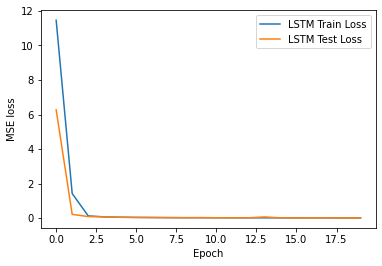

In [52]:
mer8motif_lstm_data_label = list(zip([mer8motif_train_losses_lstm,mer8motif_test_losses_lstm], ['LSTM Train Loss','LSTM Test Loss']))
u.quick_loss_plot(mer8motif_lstm_data_label)

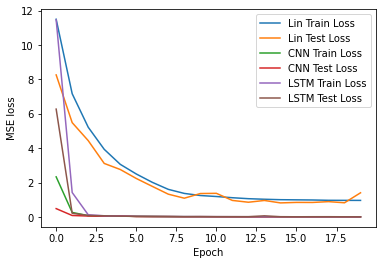

In [53]:
u.quick_loss_plot(
    mer8motif_lin_data_label + \
    mer8motif_cnn_data_label + \
    mer8motif_lstm_data_label
)